In [1]:
import pandas as pd
import numpy as np
import re
import shutil
import os
import string
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.cross_validation import StratifiedKFold,  train_test_split
import statsmodels.stats.api as sms
from IPython.display import display

from build_model import EkgClassification
%pylab inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import product 
def trigrams():
    tokens = []
    for token in product(string.ascii_uppercase, repeat=3):

        if token[0] > 'F':
            break

        if token[1] > 'F' or token[2] > 'F':
            continue

        tokens.append(''.join(token))
    return tokens
trs = trigrams()

In [3]:
def create_vw(X_train, y_train, file_res, file_true_labels):
    ind_dis = y_train[y_train == 1].index
    data = X_train.T.apply(OrderedDict)

    with open(file_true_labels + '.txt', 'w') as lab:
        with open(file_res + '.txt', 'w') as fout:
            for key, value  in zip(data.index, data):
                fout.write('{} '.format(key))

                for tr, freq in value.items():
                    fout.write('{}:{} '.format(tr, freq))

                fout.write('|labels ')

                if key in ind_dis:
                    fout.write('{}:{} '.format('label0', 0))
                    fout.write('{}:{}'.format(' label1', 1))
                    lab.write('1')
                else:
                    fout.write('{}:{}'.format('label0', 1))
                    fout.write('{}:{}'.format(' label1', 0))
                    lab.write('0')

                fout.write('\n')
                lab.write('\n')
    np.save(file_res + '.npy', X_train.values)
    np.save(file_true_labels + '.npy', y_train.values) 
    
def create_valid_vw(X_train, y_train, file_res, file_true_labels):
    ind_dis = y_train[y_train == 1].index
    data = X_train.T.apply(OrderedDict)

    with open(file_true_labels + '.txt', 'w') as lab:
        with open(file_res + '.txt', 'w') as fout:
            for key, value  in zip(data.index, data):
                fout.write('{} '.format(key))

                for tr, freq in value.items():
                    fout.write('{}:{} '.format(tr, freq))

                fout.write('|labels ')

                if key in ind_dis:
                    lab.write('1')
                else:
                    lab.write('0')

                fout.write('\n')
                lab.write('\n')
    np.save(file_res + '.npy', X_train.values)
    np.save(file_true_labels + '.npy', y_train.values)

In [4]:
def reject_shuffle(idxs, n_shuffles):
    orders = set()       
    for i in range(n_shuffles):
        while tuple(idxs) in orders:
            np.random.shuffle(idxs)
        orders.add(tuple(idxs))
    for idx in orders:
        yield idx

def create_shuffled_vws(file_src, file_true_labels, n_shuffles):
    with open(file_src + '.txt', 'r') as fin:
        data = fin.readlines()
    data_arr = np.load(file_src + '.npy')

    with open(file_true_labels + '.txt', 'r') as fin:
        y_true = fin.readlines()
    y_true_arr = np.load(file_true_labels + '.npy')
    
    idxs = np.arange(data_arr.shape[0])
    for i, idx in enumerate(reject_shuffle(idxs, n_shuffles)):
        idx_val = np.array(idx, dtype=int)
        data_shuffle = np.array(data)[idx_val]
        y_true_shuffle = np.array(y_true)[idx_val]
        
        data_arr_shuffle = data_arr[idx_val]
        y_true_arr_shuffle = y_true_arr[idx_val]
    
        with open('{}{}.txt'.format(file_src, i), 'w') as fout:
            fout.write(''.join(data_shuffle))
        np.save('{}{}.npy'.format(file_src, i), data_arr_shuffle)
        
        with open('{}{}.txt'.format(file_true_labels, i), 'w') as fout:
            fout.write(''.join(y_true_shuffle))
        np.save('{}{}.npy'.format(file_true_labels, i), y_true_arr_shuffle)

In [5]:
n_dis = 69
n_health = 1

data = pd.read_csv('data.txt', sep='\t')
data.columns = ['n_record', 'n_observ'] + list(range(1, 137))

p3 = pd.read_csv('p3.txt', sep='\t')
p3.columns  = trs

ind_health = data[n_health] == 1
ind_dis = data[n_dis] == 1

data_health = p3.loc[ind_health]
data_dis = p3.loc[ind_dis]

data_all = pd.concat([data_health, data_dis], axis=0)
target = 'p_chronic_cholecystitis'
data_all[target] = 0
data_all.loc[ind_dis, target]  = 1

X_train, X_valid, y_train, y_valid = \
                      train_test_split(data_all[trs], data_all[target],
                                        test_size=0.3, random_state=241) 

n_shuffles = 10
#create_vw(X_train, y_train, 'vw_train', 'true_labels_train')
#create_vw(X_valid, y_valid, 'vw_valid', 'true_labels_valid')
#create_shuffled_vws('vw_train', 'true_labels_train', n_shuffles)

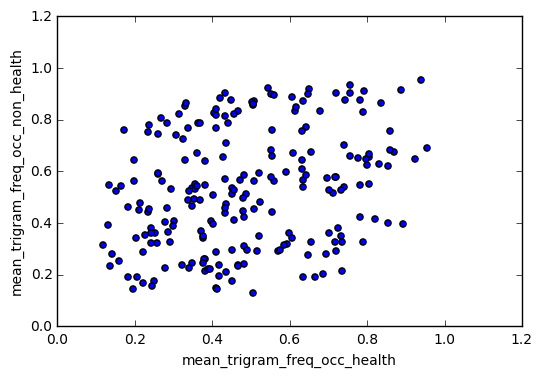

In [7]:
data_bin = (data_all[trs] > 0).astype(int)

xlabel('mean_trigram_freq_occ_health')
ylabel('mean_trigram_freq_occ_non_health')
scatter(data_bin[ind_health].mean(axis=0), data_bin[~ind_health].mean(axis=0), cmap=cm.coolwarm)

In [8]:
def NaiveBayes(X_train, y_train, X_test, y_test, k, *args):
    #X_train_bin = (X_train >= bin_thr).astype(int)
    #X_test_bin = (X_test >= bin_thr).astype(int)
    
    p_cw = np.zeros((2, k))
    p_cw[0, :] = X_train[y_train == 0].sum(axis=0) 
    p_cw[1, :] = X_train[y_train == 1].sum(axis=0)  
    p_cw /= X_train.sum(axis=0) 
    p_cw[np.isnan(p_cw)] = 0.5
    
    probas_train = p_cw.dot(X_train.T) 
    probas_test = p_cw.dot(X_test.T) 
    
    predict_train = probas_train[1] 
    predict_train /= predict_train.max() or 1
    
    predict_test = probas_test[1] 
    predict_test /= predict_test.max() or 1

    return (roc_auc_score(y_train, predict_train),
            roc_auc_score(y_test, predict_test),
            log_loss(y_train, predict_train),
            log_loss(y_test, predict_test))

In [31]:
def sindrom_algorithm(X_train, y_train, X_test, y_test, k, bin_thr, type_weights):
    X_train_bin = (X_train >= bin_thr).astype(int)
    X_test_bin = (X_test >= bin_thr).astype(int)
    
    n_dis = np.count_nonzero(y_train)

    sort_values_dis = (X_train_bin[y_train == 1].sum(
        axis=0) + 1.0) / (n_dis + 2.0)
    sort_values_health = (X_train_bin[y_train == 0].sum(
        axis=0) + 1.0) / (y_train.shape[0] - n_dis + 2.0)

    selected_feat = np.argsort(sort_values_dis)[::-1][:k]

    if type_weights == 1:
        weights = np.log(sort_values_dis * (1 - sort_values_health)) - \
            np.log(sort_values_health * (1 - sort_values_dis))
    else:
        weights = np.mean(X_train_bin[y_train == 1], axis=0) - np.mean(X_train_bin[y_train == 0], axis=0)
        
    final_weights = np.zeros(weights.shape)
    final_weights[selected_feat] = weights[selected_feat]

    predict_train = X_train_bin.dot(final_weights.reshape(final_weights.shape[0], 1))
    predict_train /= predict_train.max() or 1
    
    predict_test = X_test_bin.dot(final_weights.reshape(final_weights.shape[0], 1))
    predict_test /= predict_test.max() or 1
    
    return (roc_auc_score(y_train, predict_train),
            roc_auc_score(y_test, predict_test),
            log_loss(y_train, predict_train),
            log_loss(y_test, predict_test))

In [96]:
def cross_val_score(model, n_shuffles, n_folds, klist, bin_thrlist, *args):
    auc_folds = {}
    logloss_folds = {}
    for k in klist:
        for bin_thr in bin_thrlist:
            key = (k, bin_thr)
            auc_folds[key] = []
            logloss_folds[key] = []
        
    for n_shuffle in range(n_shuffles):
        X_train = np.load('vw_train{}.npy'.format(n_shuffle))
        y_train = np.load('true_labels_train{}.npy'.format(n_shuffle))
        
        for k in klist:
            for bin_thr in bin_thrlist:
                key = (k, bin_thr)
                skf = StratifiedKFold(y_train, n_folds, random_state=241)
                for n_fold, (i, j) in enumerate(skf):
                    (_, auc,
                     _, logloss) =  model(X_train[i],
                                          y_train[i],
                                          X_train[j],
                                          y_train[j],
                                          k,
                                          bin_thr,
                                          args[0] if args else 0)
                    auc_folds[key].append(auc)
                    logloss_folds[key].append(logloss)
           
    mean_auc = {}
    mean_logloss = {}
    
    for key in auc_folds.keys():
        mean_auc[key] = np.mean(auc_folds[key])
        mean_logloss[key] = np.mean(logloss_folds[key])
        
    return (mean_auc, 
            mean_logloss)

In [83]:
def sindrom_algorithm_score(n_shuffles,
                            n_folds,
                            klist,
                            bin_thrlist,
                            type_weights):
    (mean_auc, mean_logloss) =\
                        cross_val_score(sindrom_algorithm,
                                        n_shuffles,
                                        n_folds,
                                        klist,
                                        bin_thrlist,
                                        type_weights)

    figure(figsize=(10, 5))

    xlim([min(klist), max(klist)])
    ylim([0.5, 1])
    xticks(arange(1, max(klist), 10))
    xlabel('k', fontsize=18)
    ylabel('AUC', fontsize=18)
    values = []
    keys = []
    for key, value in sorted(mean_auc.items()):
        values.append(value)
        keys.append(key)
    plot(keys, values, color='magenta', lw=3)
    legend(['TrainCV'], fontsize=18, loc='best')
    savefig('auc_SA_type_weights:{}.png'.format(type_weights))
    show()

    figure(figsize=(10, 5))
    xlim([min(klist), max(klist)])
    xticks(arange(1, max(klist), 10))
    xlabel('k', fontsize=18)
    ylabel('LogLoss', fontsize=18)
    values = []
    keys = []
    for key, value in sorted(mean_logloss.items()):
        values.append(value)
        keys.append(key)
    plot(keys, values, color='purple', lw=3)
    legend(['TrainCV'], fontsize=18, loc='best')
    savefig('logloss_SA_type_weights:{}.png'.format(type_weights))
    show()
    best_key = max(mean_auc, key=lambda i: mean_auc[i])
    print 'SA. Type_weights:{}. Best_param:{}'.format(type_weights, best_key)
    return best_key, mean_auc, mean_logloss

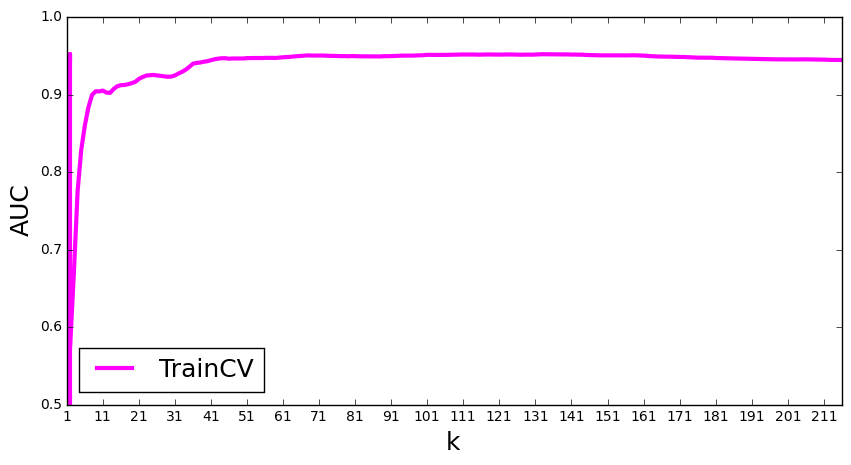

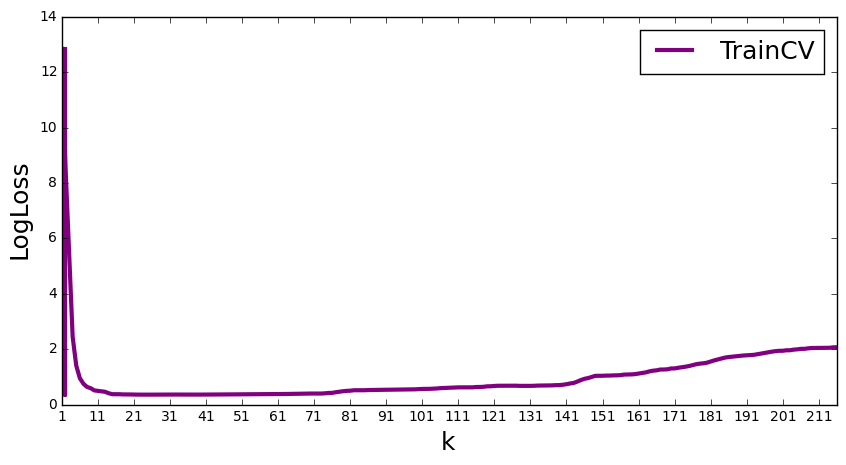

SA. Type_weights:1. Best_param:(133, 2)


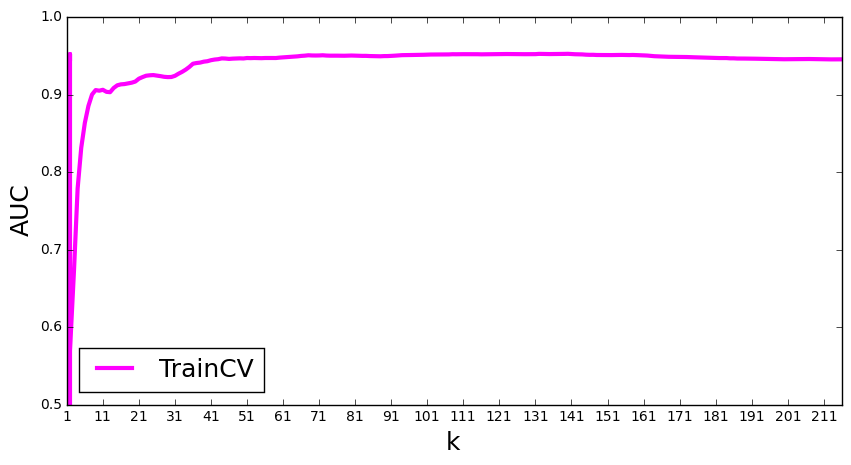

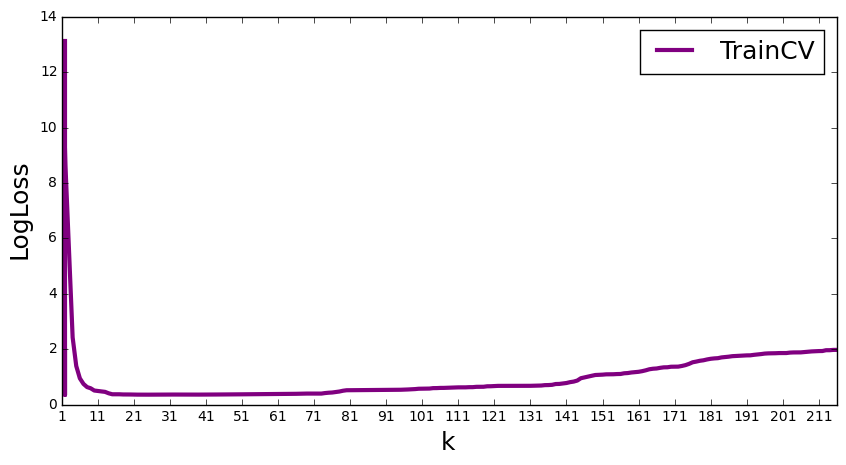

SA. Type_weights:2. Best_param:(140, 2)


In [103]:
scores = {}
n_shuffles = 10
n_folds = 10
klist = range(1, 217)
bin_thrlist = [2]
type_weights = 1

best_key, mean_auc, mean_logloss = \
                sindrom_algorithm_score(n_shuffles, n_folds, klist, bin_thrlist, type_weights)
scores['SA_type_weights:{}'.format(type_weights)]  = \
        OrderedDict([             
           ('AUC(TrainCV)', mean_auc[best_key]), 
           ('LogLoss(TrainCV)', mean_logloss[best_key])])
    
type_weights = 2

best_key, mean_auc, mean_logloss = \
                sindrom_algorithm_score(n_shuffles, n_folds, klist, bin_thrlist, type_weights)
scores['SA_type_weights:{}'.format(type_weights)]  = \
        OrderedDict([             
           ('AUC(TrainCV)', mean_auc[best_key]), 
           ('LogLoss(TrainCV)', mean_logloss[best_key])])
    
klist = [216]
bin_thrlist = [2]

(mean_auc, mean_logloss) = \
              cross_val_score(NaiveBayes, n_shuffles, n_folds, klist, bin_thrlist)

scores['NB']  = OrderedDict([             
    ('AUC(TrainCV)', mean_auc.values()[0]),
    ('LogLoss(TrainCV)', mean_logloss.values()[0])])

In [108]:
X_train_val = X_train.values
y_train_val = y_train.values

X_valid_val = X_valid.values
y_valid_val = y_valid.values

type_weights = 1
best_key = (133, 2)
(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = sindrom_algorithm(X_train_val,
                                    y_train_val,
                                    X_valid_val,
                                    y_valid_val,
                                    best_key[0],
                                    best_key[1], 
                                    type_weights)


scores['SA_type_weights:1']['AUC(Valid)'] =  auc_valid
scores['SA_type_weights:1']['LogLoss(Valid)'] =  logloss_valid

type_weights = 2
best_key = (140, 2)
(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = sindrom_algorithm(X_train_val,
                                    y_train_val,
                                    X_valid_val,
                                    y_valid_val,
                                    best_key[0],
                                    best_key[1], 
                                    type_weights)


scores['SA_type_weights:2']['AUC(Valid)'] =  auc_valid
scores['SA_type_weights:2']['LogLoss(Valid)'] =  logloss_valid


(auc_train, 
 auc_valid, 
 logloss_train, 
 logloss_valid) = NaiveBayes(X_train_val,
                             y_train_val,
                             X_valid_val,
                             y_valid_val,
                             216,
                             2)

scores['NB']['AUC(Valid)'] =  auc_valid
scores['NB']['LogLoss(Valid)'] =  logloss_valid

In [ ]:
data_dir = 'data_ekg'
n_objs = 372
n_topics = 2
n_collection_passes = 25
n_document_passes = 1
n_shuffles = 10
n_folds = 10
clf = EkgClassification(data_dir, 
                        n_objs,
                        n_topics,
                        n_collection_passes, 
                        n_document_passes,
                        n_shuffles,
                        n_folds)

tau = np.hstack((np.repeat([1e2, 1e3 * 5], [5, 5]), np.repeat([1e3 * 5], [15])))
tau_phi_gram3 = np.hstack((np.hstack(([0] * 10, np.linspace(-1e2, -1e3, 10))), [-1e3] * 10)) 
w_gram3   = [1] * n_collection_passes

(auc_folds_iter, 
 logloss_folds_iter,  
 sparsity_phi_c_folds_iter, 
 sparsity_phi_gram3_folds_iter, 
 ptc) =  clf.cross_val_score(tau, w_gram3, tau_phi_gram3)

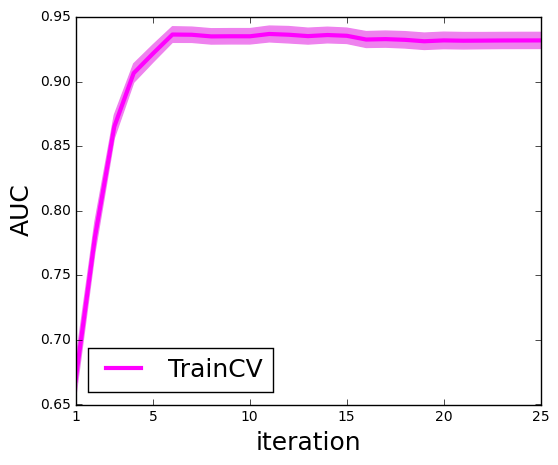

In [126]:
figure(figsize=(6, 5))

left_edge = []
right_edge = []
mean_auc = []
iters = []
for key, value in auc_folds_iter.items():
    left, right = sms.DescrStatsW(value).tconfint_mean()
    left_edge.append(left)
    right_edge.append(right)
    iters.append(key + 1)
    mean_auc.append(np.mean(value))


fill_between(iters, left_edge, right_edge, color='violet')
plot(iters, mean_auc, color='magenta', lw=3)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])
xticks(list(xticks()[0][1:]) + [1])

ylabel('AUC', fontsize=18)
legend(['TrainCV'], fontsize=18, loc='best')
savefig('auc.png')
show()

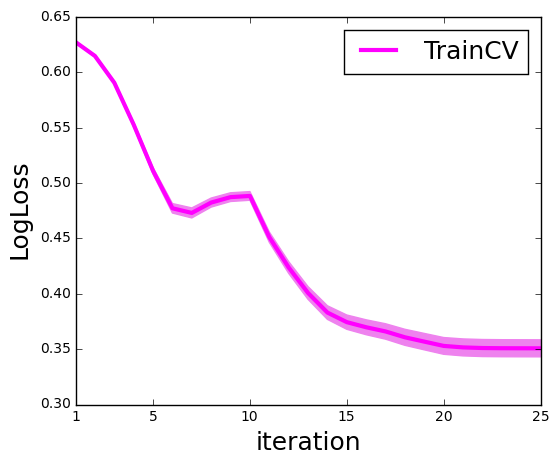

In [127]:
figure(figsize=(6, 5))

left_edge = []
right_edge = []
mean_logloss = []
iters = []
for key, value in logloss_folds_iter.items():
    left, right = sms.DescrStatsW(value).tconfint_mean()
    left_edge.append(left)
    right_edge.append(right)
    iters.append(key + 1)
    mean_logloss.append(np.mean(value))


fill_between(iters, left_edge, right_edge, color='violet')
plot(iters, mean_logloss, color='magenta', lw=3)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])
xticks(list(xticks()[0][1:]) + [1])

ylabel('LogLoss', fontsize=18)
legend(['TrainCV'], fontsize=18, loc='best')
savefig('logloss.png')
show()

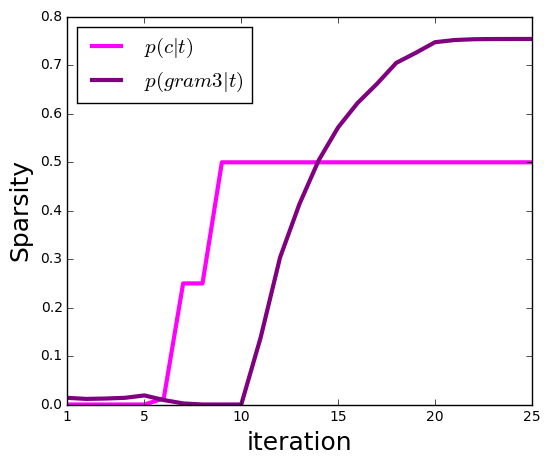

In [128]:
figure(figsize=(6, 5))

iters = []
mean_sparsity_phi_c = []
mean_sparsity_phi_gram3 = []

for key, value in sparsity_phi_c_folds_iter.items():
    iters.append(key + 1)
    mean_sparsity_phi_c.append(np.mean(value))
    
for key, value in sparsity_phi_gram3_folds_iter.items():
    mean_sparsity_phi_gram3.append(np.mean(value))

plot(iters, mean_sparsity_phi_c, color='magenta', lw=3)
plot(iters, mean_sparsity_phi_gram3, color='purple', lw=3)

xlabel('iteration', fontsize=18)
xlim([1, n_collection_passes])
xticks(list(xticks()[0][1:]) + [1])
ylabel('Sparsity', fontsize=18)
legend([r'$p(c|t)$', r'$p(gram3|t)$'], loc = 'best', fontsize = 15)
savefig('sparsity.png')
show()

In [ ]:
scores['PLSA']  = OrderedDict([             
    ('AUC(TrainCV)', mean_auc[-1]),
    ('LogLoss(TrainCV)', mean_logloss[-1])])

os.mkdir(data_dir)
shutil.copy('true_labels_train.txt', os.path.join(data_dir, 'true_labels_train.txt'))
shutil.copy('true_labels_valid.txt', os.path.join(data_dir, 'true_labels_test.txt'))
shutil.copy('vw_train.txt', os.path.join(data_dir, 'train.txt'))
shutil.copy('vw_valid.txt', os.path.join(data_dir, 'test.txt'))
(_, auc_valid, 
 _, logloss_valid
 sparsity_phi_c,
 sparsity_phi_gram3,
 p_tc) = clf.valid_score(
                    data_dir,
                    'true_labels_train.txt',
                    'true_labels_test.txt',
                     tau,
                     w_gram3,
                     tau_phi_gram3)

scores['PLSA']['AUC(Valid)'] =  auc_train[-1]
scores['PLSA']['LogLoss(Valid)'] =  logloss_train[-1]
shutil.rmtree(data_dir)

In [196]:
models = []
model_scores = []
for model, score in sorted(scores.items()):
    models.append(model)
    model_scores.append(score)
    
df = pd.DataFrame(model_scores, columns = ['model'] + scores['NB'].keys())
df['model'] = models
display(df)

,model,AUC(TrainCV),LogLoss(TrainCV),AUC(Valid),LogLoss(Valid)
0,NB,0.932344,0.426228,0.915492,0.453726
1,PLSA,0.931873,0.350741,0.905615,0.382080
2,SA_type_weights:1,0.951964,0.683448,0.928156,0.906411
3,SA_type_weights:2,0.952503,0.761887,0.929032,1.047279


In [198]:
df.to_csv('models.csv', index_col=0)